In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.cm as cm
from scipy.interpolate import interp1d,griddata
from salishsea_tools import (nc_tools, gsw_calls,viz_tools)
import cmocean.cm as cm
from fancyimpute import KNN

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
init_file = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_NEMO_IC_high_resolution_wide_bdy.nc')

nc_tools.show_dimensions(init_file);
nc_tools.show_variables(init_file);

<class 'netCDF4._netCDF4.Dimension'>: name = 'xb', size = 290

<class 'netCDF4._netCDF4.Dimension'>: name = 'yb', size = 390

<class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 40

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 1

odict_keys(['nav_lat', 'nav_lon', 'deptht', 'time_counter', 'votemper', 'vosaline'])


In [7]:
votemper_NEMO = init_file.variables['votemper'][0,...]
vosaline_NEMO = init_file.variables['vosaline'][0,...]
zlevels = init_file.variables['deptht'][:]
lat = init_file.variables['nav_lat'][:]
lon = init_file.variables['nav_lon'][:]

In [8]:
vosaline_NEMO.shape

(40, 390, 290)

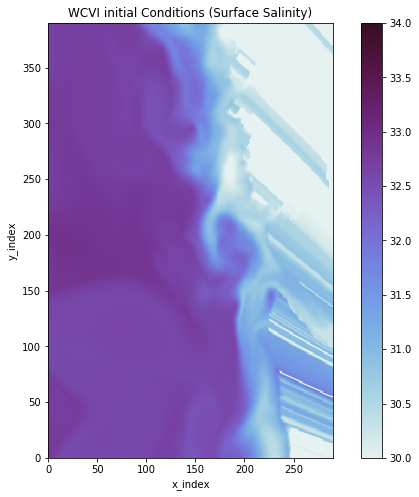

In [18]:
bathy = '/ocean/ssahu/CANYONS/wcvi/grid/bathy_files/bathy_meter_high_res_cubic_truncated_flatten_2000m.nc'

bathymetry = nc.Dataset(bathy).variables['Bathymetry'][:]

y_slice = np.arange(0, 390)
x_slice = np.arange(0, 290)


fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
#cmap = plt.get_cmap('winter_r')
#cmap.set_bad('burlywood')
mesh = ax.pcolormesh(vosaline_NEMO[0,...], vmin =30, vmax=34, cmap=cm.dense)
# viz_tools.plot_land_mask(ax, bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
# viz_tools.plot_coastline(ax, bathy, color = 'burlywood')
ax.set_xlabel('x_index')
ax.set_ylabel('y_index')
ax.set_title('WCVI initial Conditions (Surface Salinity)')
fig.colorbar(mesh)

In [22]:
vosaline_NEMO.shape

(40, 390, 290)

In [23]:
np.min(vosaline_NEMO)

27.723017

In [21]:
np.where(vosaline_NEMO == np.min(vosaline_NEMO))

(array([0]), array([237]), array([289]))

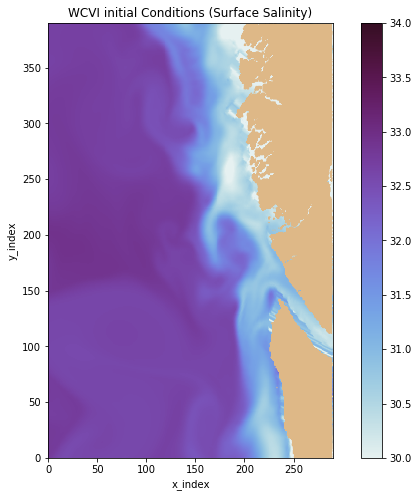

In [9]:
bathy = '/ocean/ssahu/CANYONS/wcvi/grid/bathy_files/bathy_meter_high_res_cubic_truncated_flatten_2000m.nc'

bathymetry = nc.Dataset(bathy).variables['Bathymetry'][:]

y_slice = np.arange(0, 390)
x_slice = np.arange(0, 290)


fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
#cmap = plt.get_cmap('winter_r')
#cmap.set_bad('burlywood')
mesh = ax.pcolormesh(vosaline_NEMO[0,...], vmin =30, vmax=34, cmap=cm.dense)
viz_tools.plot_land_mask(ax, bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
viz_tools.plot_coastline(ax, bathy, color = 'burlywood')
ax.set_xlabel('x_index')
ax.set_ylabel('y_index')
ax.set_title('WCVI initial Conditions (Surface Salinity)')
fig.colorbar(mesh)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


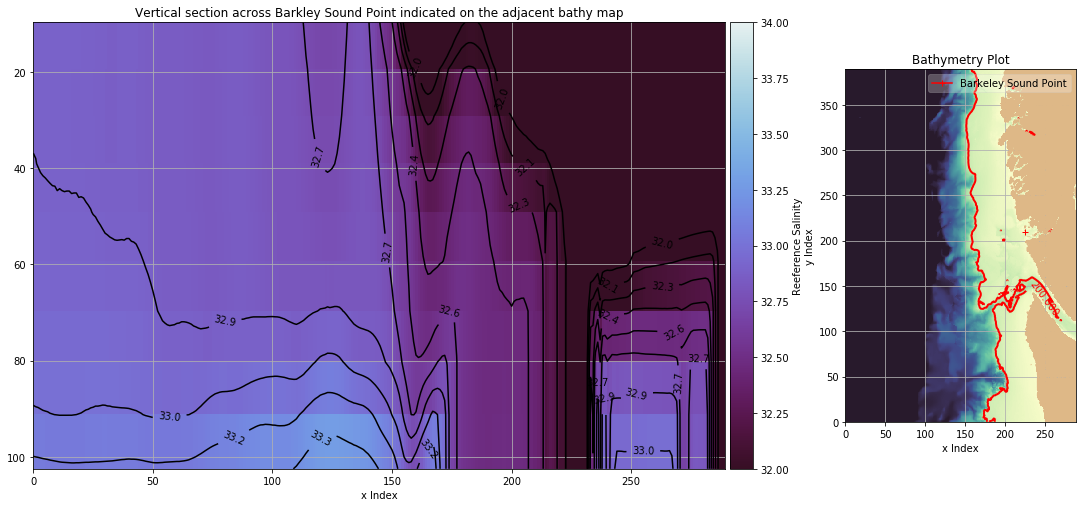

In [16]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, bathymetry, cmap=cm.deep)
axr.plot(
    x_slice[225], y_slice[210],
    linestyle='-', marker='+', color='Red',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
viz_tools.set_aspect(axr)
viz_tools.plot_land_mask(axr, bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
viz_tools.plot_coastline(axr, bathy, color = 'burlywood')
CS = axr.contour(x_slice,y_slice,bathymetry, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

sal_0 = vosaline_NEMO[:,:,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:10])
mesh = axl.pcolormesh(x_slice, zlevels[:10], sal_tzyx[:10,210,x_slice], cmap=cm.dense_r, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reeference Salinity')
clines = axl.contour(x_slice, zlevels[:10], sal_tzyx[:10,210,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map')

In [41]:
np.isnan(vosaline_NEMO[...])

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, 

In [10]:
np.where(np.isnan(vosaline_NEMO[0,...]))

(array([  0,   0,   0, ..., 389, 389, 389]),
 array([ 23,  24,  25, ..., 287, 288, 289]))

In [18]:
# try:
#     for i in np.arange(votemper_NEMO.shape[1]):
#         votemper_NEMO[0,i,...] = KNN(k=3).complete(votemper_NEMO[0,i,...])
#         vosaline_NEMO[0,i,...] = KNN(k=3).complete(vosaline_NEMO[0,i,...])
# except:
#     pass


for i in np.arange(votemper_NEMO.shape[0]):
    votemper_NEMO[i,...] = KNN(k=3).complete(votemper_NEMO[i,...])
    vosaline_NEMO[i,...] = KNN(k=3).complete(vosaline_NEMO[i,...])

Imputing row 1/390 with 275 missing, elapsed time: 0.034
Imputing row 101/390 with 290 missing, elapsed time: 0.180
Imputing row 201/390 with 290 missing, elapsed time: 0.318
Imputing row 301/390 with 290 missing, elapsed time: 0.456
[KNN] Warning: 112650/113100 still missing after imputation, replacing with 0
Imputing row 1/390 with 267 missing, elapsed time: 0.034
Imputing row 101/390 with 290 missing, elapsed time: 0.181
Imputing row 201/390 with 290 missing, elapsed time: 0.323
Imputing row 301/390 with 290 missing, elapsed time: 0.465
[KNN] Warning: 112019/113100 still missing after imputation, replacing with 0
Imputing row 1/390 with 267 missing, elapsed time: 0.036
Imputing row 101/390 with 290 missing, elapsed time: 0.180
Imputing row 201/390 with 290 missing, elapsed time: 0.320
Imputing row 301/390 with 290 missing, elapsed time: 0.459
[KNN] Warning: 112019/113100 still missing after imputation, replacing with 0
Imputing row 1/390 with 267 missing, elapsed time: 0.036
Imputin

In [19]:
np.where(np.isnan(vosaline_NEMO[0,...]))

(array([], dtype=int64), array([], dtype=int64))

In [21]:
vosaline_NEMO[0,...]

array([[ 32.77190399,  32.77790451,  32.78390121, ...,   0.        ,
          0.        ,   0.        ],
       [ 32.76890182,  32.77480698,  32.77990341, ...,   0.        ,
          0.        ,   0.        ],
       [ 32.76490402,  32.77180481,  32.77680588, ...,   0.        ,
          0.        ,   0.        ],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]], dtype=float32)

In [19]:
for i,j in enumerate(votemper_NEMO[:,...]):
    for p,q in enumerate(votemper_NEMO[i,:,...]):
        for l,m in enumerate(votemper_NEMO[i,p,:]):
            if np.isnan(votemper_NEMO[i,p,l]):
                votemper_NEMO[i,p,l] = votemper_NEMO[i-1,p,l]
            else:
                continue

                
for i,j in enumerate(vosaline_NEMO[:,...]):
    for p,q in enumerate(vosaline_NEMO[i,:,...]):
        for l,m in enumerate(vosaline_NEMO[i,p,:]):
            if np.isnan(vosaline_NEMO[i,p,l]):
                vosaline_NEMO[i,p,l] = vosaline_NEMO[i-1,p,l]
            else:
                continue


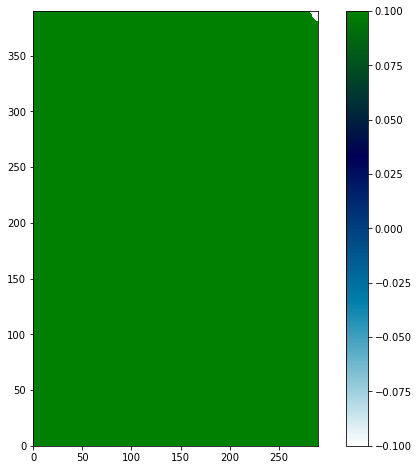

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(vosaline_ic[0,...], cmap =cm.ocean_r)
fig.colorbar(mesh)
plt.show()

In [23]:
np.nanmean(vosaline_NEMO)

33.125713

In [26]:
np.where(np.isnan(vosaline_NEMO[0,...]))

(array([  0,   0,   0, ..., 389, 389, 389]),
 array([ 23,  24,  25, ..., 287, 288, 289]))

In [28]:
gridU = xr.open_dataset('/home/ssahu/saurav/JP_BC/cat_43_U.nc')
gridV = xr.open_dataset('/home/ssahu/saurav/JP_BC/cat_43_V.nc')


nav_lon_U = np.array(gridU['nav_lon'][55:400,446:701])
nav_lat_U = np.array(gridU['nav_lat'][55:400,446:701])

nav_lon_V = np.array(gridV['nav_lon'][55:400,446:701])
nav_lat_V = np.array(gridV['nav_lat'][55:400,446:701])

U_vel_BC_unfiltered = np.array(gridU['vozocrtx'][1:,:,55:400,446:701])
V_vel_BC_unfiltered = np.array(gridV['vomecrty'][1:,:,55:400,446:701])

In [32]:
mask = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/meshmask_files/JP_mesh_mask.nc')

tmask_JP = mask.variables['tmask'][0,:,55:400,446:701]
umask_JP = mask.variables['umask'][0,:,55:400,446:701]
vmask_JP = mask.variables['vmask'][0,:,55:400,446:701]


In [30]:
U_vel_BC_unfiltered.shape

(42, 50, 345, 255)

In [31]:
np.where(U_vel_BC_unfiltered[0,0,...] == 0)

(array([  0,   0,   0, ..., 344, 344, 344]),
 array([218, 219, 220, ..., 252, 253, 254]))

In [35]:
for i in np.arange(U_vel_BC_unfiltered.shape[0]):
    U_vel_BC_unfiltered[i,...] = np.ma.masked_array(U_vel_BC_unfiltered[i,...], mask = umask_JP[...])
    
U_vel_BC_unfiltered[U_vel_BC_unfiltered == 0] = ['Nan'];

In [37]:
np.where(U_vel_BC_unfiltered[...] == 0)

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [40]:
try:
    for i in np.arange(U_vel_BC_unfiltered.shape[0]):
        for j in np.arange(U_vel_BC_unfiltered.shape[1]):
            U_vel_BC_unfiltered[i,...] = KNN(k=3).complete(U_vel_BC_unfiltered[i,j,...])
except:
    pass

Imputing row 1/345 with 37 missing, elapsed time: 0.358
Imputing row 101/345 with 46 missing, elapsed time: 0.497
Imputing row 201/345 with 21 missing, elapsed time: 0.579
Imputing row 301/345 with 127 missing, elapsed time: 0.653


In [41]:
np.where(np.isnan(U_vel_BC_unfiltered))

(array([ 1,  1,  1, ..., 41, 41, 41]),
 array([ 0,  0,  0, ..., 49, 49, 49]),
 array([  0,   0,   0, ..., 344, 344, 344]),
 array([218, 219, 220, ..., 252, 253, 254]))

In [45]:
for i in np.arange(0):#(U_vel_BC_unfiltered.shape[0]):
    for j in np.arange(U_vel_BC_unfiltered.shape[1]):
        for k in np.arange(U_vel_BC_unfiltered.shape[2]):
            for l in np.arange(U_vel_BC_unfiltered.shape[3]):
                if np.isnan(U_vel_BC_unfiltered[i,j,k,l]):
                    U_vel_BC_unfiltered[i,j,k,l] = U_vel_BC_unfiltered[i,j-1,k,l]
                else:
                    continue

In [46]:
np.where(np.isnan(U_vel_BC_unfiltered[0,...]))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [ ]:
for i in np.arange(U_vel_BC_unfiltered.shape[0]):
    for p in np.arange(U_vel_BC_unfiltered.shape[1]):
        for l in np.arange(U_vel_BC_unfiltered.shape[2]):
            if np.isnan(U_vel_BC_unfiltered[i,p,l]):
                U_vel_BC_unfiltered[i,p,l] = U_vel_BC_unfiltered[i-1,p,l]
            else:
                continue

In [ ]:
print("Copying the values all the way across")

for i in np.arange(votemper_NEMO.shape[0]):
    for p in np.arange(votemper_NEMO.shape[1]):
        for l in np.arange(votemper_NEMO.shape[2]):
            if np.isnan(votemper_NEMO[i,p,l]):
                votemper_NEMO[i,p,l] = votemper_NEMO[i,p-1,l]
            else:
                continue


for i in np.arange(vosaline_NEMO.shape[0]):
    for p in np.arange(vosaline_NEMO.shape[1]):
        for l in np.arange(vosaline_NEMO.shape[2]):
            if np.isnan(vosaline_NEMO[i,p,l]):
                vosaline_NEMO[i,p,l] = vosaline_NEMO[i,p-1,l]
            else:
                continue

In [39]:
np.where(np.isnan(U_vel_BC_unfiltered))

(array([ 0,  0,  0, ..., 41, 41, 41]),
 array([ 0,  0,  0, ..., 49, 49, 49]),
 array([  0,   0,   0, ..., 344, 344, 344]),
 array([218, 219, 220, ..., 252, 253, 254]))

In [34]:
np.where(U_vel_BC_unfiltered[0,0,...] == 0)

(array([  0,   0,   0, ..., 344, 344, 344]),
 array([218, 219, 220, ..., 252, 253, 254]))

In [3]:
fname = '/home/ssahu/saurav/JP_BC/cat_42_days_T.nc'

gridT = xr.open_dataset(fname)

mask = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/meshmask_files/JP_mesh_mask.nc')

tmask_JP = mask.variables['tmask'][0,:,55:420,446:730]

votemper_JP = np.array(gridT['votemper'][1,:,55:420,446:730]) #Our 1st day of NEMO run (set in namelist and atmos files from that day)  is second day of data which starts from beginning of month
votemper_JP[...] = np.ma.masked_array(votemper_JP[...], mask = tmask_JP[...])
votemper_JP[votemper_JP == 0] =['Nan']

vosaline_JP = np.array(gridT['vosaline'][1,:,55:420,446:730])
vosaline_JP[...] = np.ma.masked_array(vosaline_JP[...], mask = tmask_JP[...])
vosaline_JP[vosaline_JP == 0] = ['Nan']

glamt_bc_JP = np.array(gridT['nav_lon'][55:420,446:730])
gphit_bc_JP = np.array(gridT['nav_lat'][55:420,446:730])
deptht_JP = np.array(gridT['deptht'][:])


In [68]:
np.isnan(vosaline_JP)

array([[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ..., 
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ..., 
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ..., 
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True, 

In [8]:
fname_wcvi = '/ocean/ssahu/CANYONS/wcvi/grid/coordinates.nc'

with nc.Dataset(fname_wcvi, 'r') as coord:
    gphit_wcvi = coord.variables['gphit'][0,...];
    glamt_wcvi =  coord.variables['glamt'][0,...];

X = glamt_bc_JP.flatten();

Y = gphit_bc_JP.flatten();

points = (X[:],Y[:]);

xi = (glamt_wcvi.flatten(), gphit_wcvi.flatten());

votemper_ic = np.empty((votemper_JP.shape[0], glamt_wcvi.shape[0], glamt_wcvi.shape[1]));
vosaline_ic = np.empty((vosaline_JP.shape[0], glamt_wcvi.shape[0], glamt_wcvi.shape[1]));



# for i in np.arange(0):#(votemper_JP.shape[0]):
votemper_ic[0,...] = np.reshape(griddata(points, votemper_JP[0,...].flatten(), xi, method= 'cubic'), glamt_wcvi.shape)
vosaline_ic[0,...] = np.reshape(griddata(points, vosaline_JP[0,...].flatten(), xi, method= 'cubic'), glamt_wcvi.shape)



NameError: name 'vosaline_ic' is not defined

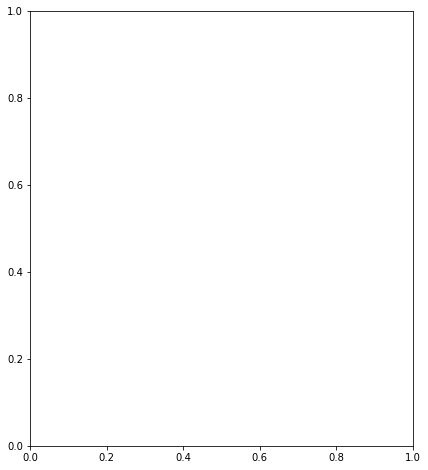

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(vosaline_ic[0,...], cmap =cm.ocean_r)
fig.colorbar(mesh)
plt.show()

In [34]:
np.nanmean(vosaline_ic[0,...])

30.740706789949844

In [35]:
vosaline_ic[np.isnan(vosaline_ic)] = 0

In [86]:
glamt_bc_JP

array([[-129.93522644, -129.90785217, -129.88046265, ..., -123.04655457,
        -123.01925659, -122.99195862],
       [-129.9339447 , -129.90655518, -129.87918091, ..., -123.04560852,
        -123.01831818, -122.9910202 ],
       [-129.93264771, -129.90527344, -129.87788391, ..., -123.04466248,
        -123.01737213, -122.99008179],
       ..., 
       [-129.31925964, -129.29249573, -129.26573181, ..., -122.59806061,
        -122.57147217, -122.54488373],
       [-129.31689453, -129.29013062, -129.26335144, ..., -122.59633636,
        -122.56975555, -122.54317474],
       [-129.31451416, -129.28775024, -129.26098633, ..., -122.59461212,
        -122.56803131, -122.5414505 ]], dtype=float32)

In [4]:
for i in np.arange(1,votemper_JP.shape[0]):
    for p in np.arange(votemper_JP.shape[1]):
        for l in np.arange(votemper_JP.shape[2]):
            if np.isnan(votemper_JP[i,p,l]):
                votemper_JP[i,p,l] = votemper_JP[i-1,p,l]
            else:
                continue


for i in np.arange(1,vosaline_JP.shape[0]):
    for p in np.arange(vosaline_JP.shape[1]):
        for l in np.arange(vosaline_JP.shape[2]):
            if np.isnan(vosaline_JP[i,p,l]):
                vosaline_JP[i,p,l] = vosaline_JP[i-1,p,l]
            else:
                continue
                
                
for i in np.arange(votemper_JP.shape[0]):
    for p in np.arange(votemper_JP.shape[1]):
        for l in np.arange(votemper_JP.shape[2]):
            if np.isnan(votemper_JP[i,p,l]):
                votemper_JP[i,p,l] = votemper_JP[i,p,l-1]
            else:
                continue


for i in np.arange(vosaline_JP.shape[0]):
    for p in np.arange(vosaline_JP.shape[1]):
        for l in np.arange(vosaline_JP.shape[2]):
            if np.isnan(vosaline_JP[i,p,l]):
                vosaline_JP[i,p,l] = vosaline_JP[i,p,l-1]
            else:
                continue
                



for i in np.arange(vosaline_JP.shape[1]):
    for j in np.arange(vosaline_JP.shape[2]):
        if np.isnan(vosaline_JP[0,i,j]):
            vosaline_JP[0,i,j] = vosaline_JP[1,i,j]
        else:
            continue
            
            
for i in np.arange(votemper_JP.shape[1]):
    for j in np.arange(votemper_JP.shape[2]):
        if np.isnan(votemper_JP[0,i,j]):
            votemper_JP[0,i,j] = votemper_JP[1,i,j]
        else:
            continue

In [18]:
np.where(np.isnan(vosaline_ic[0,...]))

(array([381, 382, 382, 383, 383, 383, 384, 384, 384, 384, 385, 385, 385,
        385, 385, 386, 386, 386, 386, 386, 387, 387, 387, 387, 387, 387,
        388, 388, 388, 388, 388, 388, 388, 389, 389, 389, 389, 389, 389,
        389, 389]),
 array([289, 288, 289, 287, 288, 289, 286, 287, 288, 289, 285, 286, 287,
        288, 289, 285, 286, 287, 288, 289, 284, 285, 286, 287, 288, 289,
        283, 284, 285, 286, 287, 288, 289, 282, 283, 284, 285, 286, 287,
        288, 289]))

In [27]:
np.isnan(vosaline_JP)

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, 

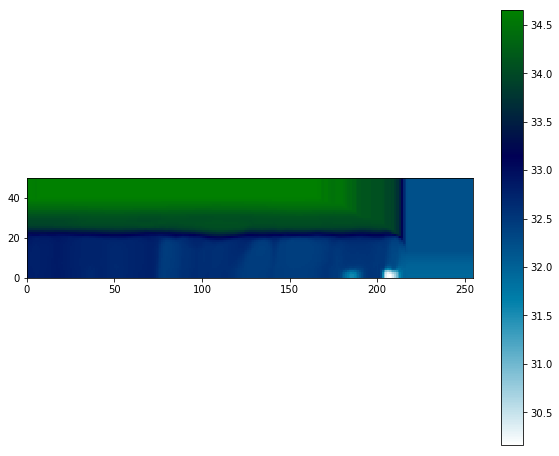

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(vosaline_JP[:,3,:], cmap =cm.ocean_r)
fig.colorbar(mesh)
plt.show()

In [40]:
vosaline_ic[np.isnan(vosaline_ic)] = 0

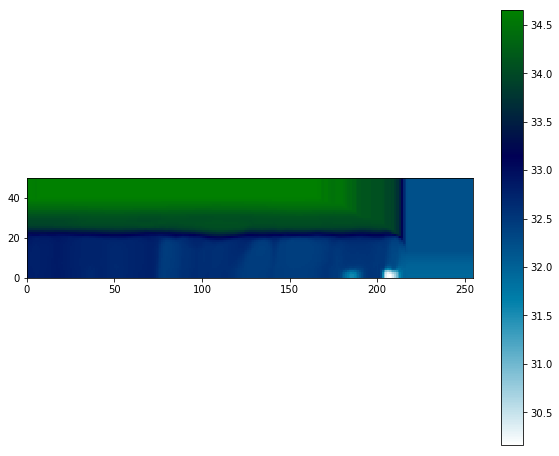

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(vosaline_JP[:,3,:], cmap =cm.ocean_r)
fig.colorbar(mesh)
plt.show()

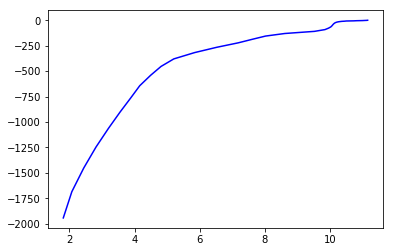

In [73]:
plt.plot(votemper_JP[:40,0,0],-deptht_JP[:40], '-b')#, vosaline_JP[:20,0,0], -deptht_JP[:20], '-g')

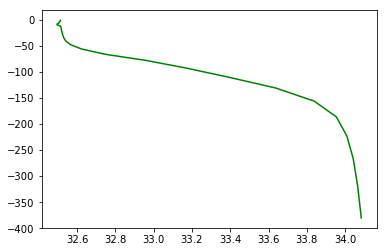

In [76]:
plt.plot(vosaline_JP[:30,3,200], -deptht_JP[:30], '-g')

In [64]:
np.isnan(vosaline_JP)

array([[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, 

In [43]:
vosaline_ic[0,...]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### Q) Is JP's output unstable ?